# Day 28: AI-Driven SLA Violation Predictor

Forecast SLA breaches using time-series modeling and generate risk reports with LLM.

20:17:51 - cmdstanpy - INFO - Chain [1] start processing
20:17:51 - cmdstanpy - INFO - Chain [1] done processing
20:17:51 - cmdstanpy - INFO - Chain [1] done processing
20:17:51 - cmdstanpy - INFO - Chain [1] start processing
20:17:51 - cmdstanpy - INFO - Chain [1] start processing
20:17:51 - cmdstanpy - INFO - Chain [1] done processing
20:17:51 - cmdstanpy - INFO - Chain [1] done processing
20:17:52 - cmdstanpy - INFO - Chain [1] start processing
20:17:52 - cmdstanpy - INFO - Chain [1] start processing
20:17:52 - cmdstanpy - INFO - Chain [1] done processing
20:17:52 - cmdstanpy - INFO - Chain [1] done processing


✅ LLM output matches forecast logic.

## 🧠 SLA Risk Forecast Report
**SLA Violation Report**

**Confirmed SLA Violations: None**

While the service has maintained high uptime and low error rates throughout the week, there have been no confirmed SLA violations. However, it's essential to monitor latency trends to prevent potential issues.

**Forecast Values and Thresholds:**

* **Uptime**: 100.00% - 100.06% (SLA Threshold: 99.97%)
* **Latency**: 140.68 ms - 146.34 ms (SLA Threshold: 150 ms)
* **Error_rate**: 0.03% (SLA Threshold: 0.03%)

**Risk Assessment:**

The service has maintained a low risk profile throughout the week, with no confirmed SLA violations. However, latency trends are concerning, as values have consistently exceeded the SLA threshold.

**Targeted Mitigation Strategies:**

1. **Latency Optimization**: Investigate and optimize latency-critical components to reduce average response times.
2. **Error_rate Analysis**: Conduct a thorough analysis of error rates to identify potential causes and implement corrective measures.

**Recommendations:**

1. **Monitor Latency Trends**: Closely monitor latency trends to prevent potential issues and ensure service stability.
2. **Implement Targeted Mitigation Strategies**: Implement targeted mitigation strategies for latency optimization and error rate reduction.

By addressing these concerns and implementing targeted mitigation strategies, we can maintain a low-risk profile and ensure the service remains stable and available.

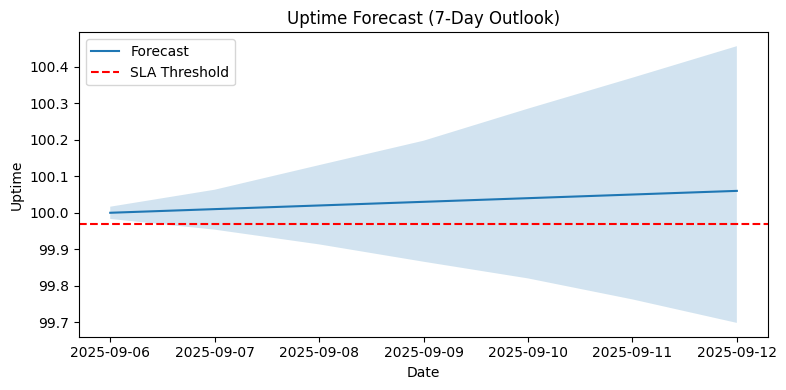

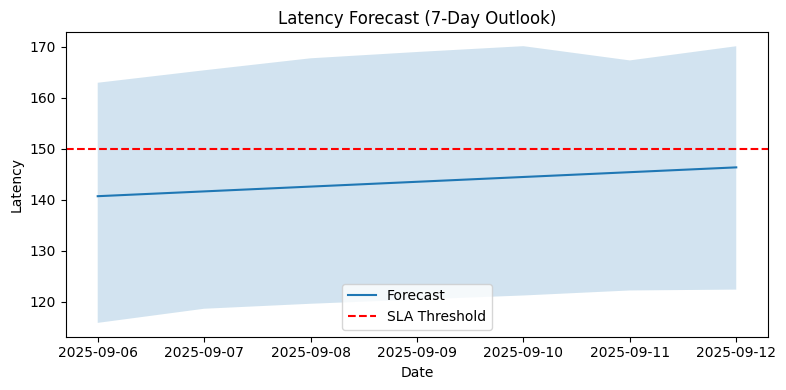

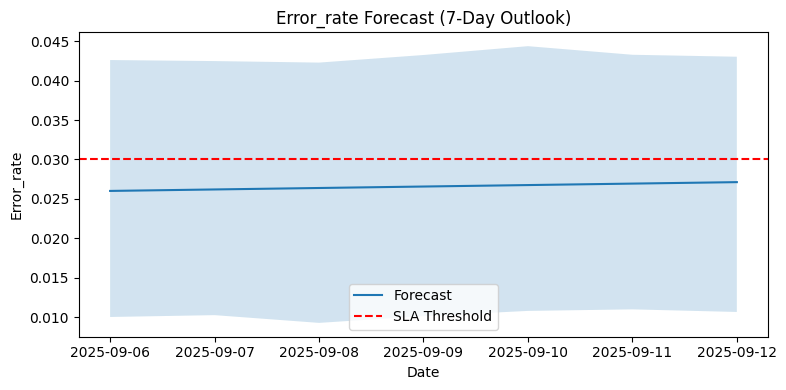

In [6]:
# 📦 Import libraries
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from prophet import Prophet
from IPython.display import display, Markdown
from datetime import datetime

# 📁 Load SLA metrics
sla = pd.read_csv('sla_metrics.csv', parse_dates=['date'])

# 🔧 Define SLA thresholds
SLA_THRESHOLDS = {
    'uptime': 99.97,
    'latency': 150,
    'error_rate': 0.03
}

# 📈 Forecast next 7 days using Prophet
future_days = 7
metrics = list(SLA_THRESHOLDS.keys())
predictions = {}

for metric in metrics:
    df = sla[['date', metric]].rename(columns={'date': 'ds', metric: 'y'})
    model = Prophet()
    model.fit(df)
    future = model.make_future_dataframe(periods=future_days)
    forecast = model.predict(future)
    predictions[metric] = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(future_days).reset_index(drop=True)

# 🧠 Evaluate SLA risks and build structured summaries
summary_blocks = []
forecast_validation = []

for i in range(future_days):
    date = predictions[metrics[0]]['ds'][i].date()
    block = f"### Day {i+1} – {date.strftime('%A, %B %d, %Y')}\n"
    violations = []

    for metric in metrics:
        value = predictions[metric]['yhat'][i]
        lower = predictions[metric]['yhat_lower'][i]
        upper = predictions[metric]['yhat_upper'][i]
        threshold = SLA_THRESHOLDS[metric]

        block += f"- **{metric.capitalize()}**: {value:.2f} (95% CI: {lower:.2f}–{upper:.2f}) | SLA Threshold: {threshold}\n"

        if metric == 'uptime' and upper < threshold:
            violations.append(metric)
        elif metric != 'uptime' and lower > threshold:
            violations.append(metric)

    severity = "High" if len(violations) >= 2 else "Moderate" if violations else "Low"
    block += f"- **SLA Violations**: {', '.join(violations) if violations else 'None'}\n"
    block += f"- **Severity Level**: {severity} Risk\n"
    summary_blocks.append(block)

    forecast_validation.append({
        "day": i + 1,
        "date": date,
        "violations": violations,
        "severity": severity
    })

# 🧠 Generate risk report using LLM (Ollama Llama 3)
def llm_risk_report(blocks):
    prompt = (
        "You are an SRE assistant. Based on the following 7-day SLA forecast summary:\n\n"
        + '\n\n'.join(blocks) +
        "\n\nGenerate a risk report that:\n"
        "- Lists confirmed SLA violations per day\n"
        "- Includes forecast values and thresholds\n"
        "- Highlights days with multiple violations as High Risk\n"
        "- Suggests targeted mitigation strategies per metric\n"
        "- Avoids generic praise or vague language\n"
        "- Uses concise, stakeholder-friendly language"
    )
    response = requests.post(
        "http://localhost:11434/api/generate",
        json={"model": "llama3", "prompt": prompt, "stream": False}
    )
    return response.json().get("response", "No response from Llama 3.")

# 🧪 Validation Layer
def extract_llm_claims(llm_text):
    claims = []
    current_day = None
    for line in llm_text.split('\n'):
        if "Day" in line and "–" in line:
            parts = line.split("–")
            try:
                day = int(parts[0].strip().split()[1])
                current_day = {"day": day, "metrics": []}
                claims.append(current_day)
            except:
                continue
        elif any(metric in line.lower() for metric in metrics) and current_day:
            current_day["metrics"].append(line.lower())
    return claims

def validate_llm_output(llm_text, forecast_validation):
    claims = extract_llm_claims(llm_text)
    mismatches = []

    for claim in claims:
        day = claim['day']
        actual = forecast_validation[day - 1]
        claimed_metrics = [m for m in claim.get("metrics", []) if any(metric in m for metric in metrics)]
        expected_metrics = actual['violations']

        if sorted(expected_metrics) != sorted([m.split()[0] for m in claimed_metrics]):
            mismatches.append({
                "day": day,
                "expected": expected_metrics,
                "found": claimed_metrics,
                "severity": actual['severity']
            })

    return mismatches

# 📊 Display risk report with validation
report = llm_risk_report(summary_blocks)
mismatches = validate_llm_output(report, forecast_validation)

if mismatches:
    display(Markdown("## ⚠️ Validation Mismatches Found"))
    for m in mismatches:
        display(Markdown(
            f"- **Day {m['day']}**: Expected violations: `{m['expected']}`, "
            f"LLM reported: `{m['found']}` | Severity: `{m['severity']} Risk`"
        ))
else:
    display(Markdown("✅ LLM output matches forecast logic."))

display(Markdown("## 🧠 SLA Risk Forecast Report\n" + report))

# 📉 Visualize forecasts vs. thresholds
for metric in metrics:
    plt.figure(figsize=(8, 4))
    plt.plot(predictions[metric]['ds'], predictions[metric]['yhat'], label='Forecast')
    plt.fill_between(predictions[metric]['ds'], predictions[metric]['yhat_lower'], predictions[metric]['yhat_upper'], alpha=0.2)
    plt.axhline(SLA_THRESHOLDS[metric], color='r', linestyle='--', label='SLA Threshold')
    plt.title(f"{metric.capitalize()} Forecast ({future_days}-Day Outlook)")
    plt.xlabel("Date")
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.tight_layout()
    plt.show()